## 그럼 추론 확률이 큰 3개의 클래스에 대해서는..?
- 무엇을 보고 어떻게 범주를 추론하는지 확인해보자.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data[0]

{'image': array([[[ 91, 101,  76],
        [160, 169, 148],
        [ 97, 105,  94],
        ...,
        [ 53,  40,  57],
        [ 53,  42,  56],
        [ 67,  57,  66]],

       [[139, 147, 124],
        [124, 131, 113],
        [ 47,  48,  42],
        ...,
        [ 49,  36,  53],
        [ 50,  39,  53],
        [ 63,  53,  62]],

       [[ 86,  90,  75],
        [ 46,  46,  36],
        [ 44,  34,  33],
        ...,
        [ 54,  42,  56],
        [ 54,  43,  57],
        [ 61,  51,  60]],

       ...,

       [[188, 180, 193],
        [193, 185, 198],
        [199, 191, 204],
        ...,
        [162, 154, 167],
        [167, 159, 172],
        [168, 160, 171]],

       [[191, 183, 196],
        [193, 185, 198],
        [196, 188, 201],
        ...,
        [162, 154, 167],
        [167, 159, 172],
        [169, 161, 172]],

       [[196, 188, 201],
        [195, 187, 200],
        [194, 186, 199],
        ...,
        [164, 156, 169],
        [170, 162, 175],
        [170, 

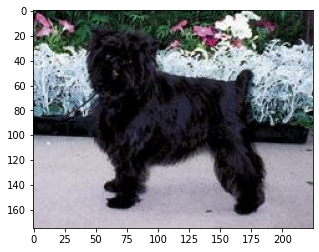

In [3]:
item = get_one(ds_test)
print(item)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 테스트 데이터는 label이 `100`인 `affenpinscher` 강아지

In [4]:
import os

num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(
        num_classes, 
        activation='softmax',
        name='softmax_layer',
    )(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/checkpoint/cam_model_best_model.weights.h5'
cam_model.load_weights(cam_model_path)

### `generate_cam_with_top_n_classes()`  
- softmax 결과값이 큰 n개의 범주에 대해서 cam 이미지를 생성하는 함수

In [14]:
def generate_cam_with_top_n_classes(model, item, n=3, debug=False):
    item = copy.deepcopy(item)
    
    # get the input image size
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, _ = normalize_and_resize_img(item)
    
    cam_output_model = tf.keras.models.Model(
        [model.inputs],
        # output : conv5_block3_out and predicted label
        [model.layers[-3].output, model.output])
    # add batch dimension
    conv_output, predictions = cam_output_model(tf.expand_dims(img_tensor, 0))
    top_n_classes = np.argsort(predictions[0])[-n:][::-1]
    if debug:
        print(top_n_classes)
        for idx in top_n_classes:
            print(ds_info.features['label'].int2str(idx))
        
    # remove batch dimension
    conv_output = conv_output[0, :, :, :]
    
    # get softmax layer's weights
    class_weights = model.layers[-1].get_weights()[0] 
    # print(class_weights.shape) # num of feature maps x num of classes
    
    cam_images = []
    for top_class_idx in top_n_classes:
        cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
        for i, w in enumerate(class_weights[:, top_class_idx]):
            # multiply weights of the input label and the activation values of i-th feature map
            cam_image += w * conv_output[:, :, i]

        cam_image /= np.max(cam_image)
        cam_image = cam_image.numpy()
        cam_image = cv2.resize(cam_image, (width, height))
        cam_images.append({'label': top_class_idx, 'image': cam_image})

    return cam_images

[ 82 100  46]
n02106382-bouvier_des_flandres
n02110627-affenpinscher
n02097130-giant_schnauzer
n02106382-bouvier_des_flandres


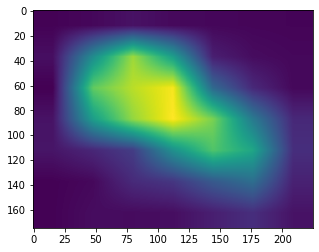

n02110627-affenpinscher


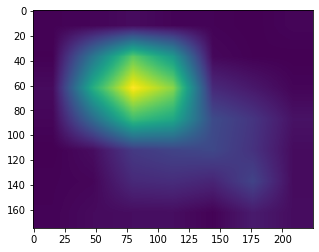

n02097130-giant_schnauzer


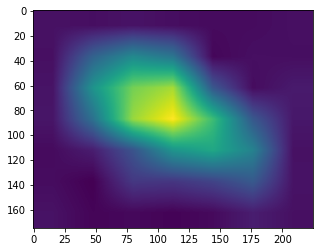

In [15]:
cam_images = generate_cam_with_top_n_classes(cam_model, item, debug=True)
for info in cam_images:
    print(ds_info.features['label'].int2str(info['label']))
    plt.imshow(info['image'])
    plt.show()

- 모델이 82, 100, 46 label을 추론 (앞에서부터 높은 확률)
- 하지만 실제 데이터의 레이블은 100
- 해당 cam 이미지를 보면 서로 비슷한 영역을 주목한 듯

In [20]:
def visualize_cam_on_image(cam_image, src_image, alpha=0.5):
    beta = 1.0 - alpha
    merged_image = cv2.addWeighted(cam_image.astype(np.uint8), alpha, src_image.astype(np.uint8), beta, 0.0)
    plt.imshow(merged_image)
    plt.show()
    return merged_image

n02106382-bouvier_des_flandres


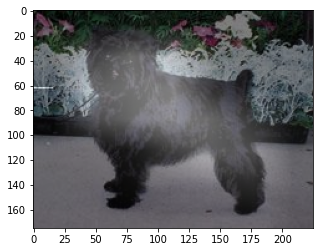

n02110627-affenpinscher


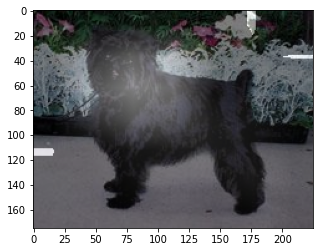

n02097130-giant_schnauzer


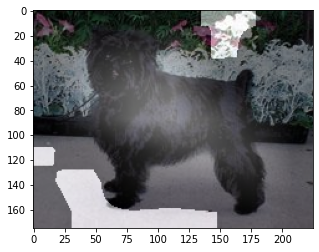

In [21]:
for info in cam_images:
    print(ds_info.features['label'].int2str(info['label']))
    cam_image = info['image']
    visualize_cam_on_image(np.stack([cam_image*255]*3, axis=-1), item['image'])

- 이미지에 오버래핑해봐도 비슷한 영역에서 특징을 본 것으로 보임

### `generate_grad_cam_with_top_n_class()`  
- softmax 결과값이 큰 n개의 범주에 대해서 grad-cam 이미지를 생성하는 함수

In [53]:
def generate_grad_cam_with_top_n_class(model, act_layer_name, item, n=3, debug=False):
    item = copy.deepcopy(item)
    
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, _ = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(act_layer_name).output, model.output]
    )
    
    conv_output, predictions = grad_model(tf.expand_dims(img_tensor, 0))
    # get top n-classes
    top_n_classes = np.argsort(predictions[0])[-n:][::-1]
    if debug:
        print(top_n_classes)
        for idx in top_n_classes:
            print(ds_info.features['label'].int2str(idx))
    
    conv_output = conv_output[0]
    
    grad_cam_images = []
    
    for class_idx in top_n_classes:
        # get gradient
        with tf.GradientTape() as tape:
            print(class_idx)
            conv_output_temp, predictions_temp = grad_model(tf.expand_dims(img_tensor, 0))
            loss = predictions_temp[:, class_idx]
            grad_val = tape.gradient(loss, conv_output_temp)[0]

        weights = np.mean(grad_val, axis=(0, 1))
        grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
        for k, w in enumerate(weights):
            grad_cam_image += w * conv_output[:, :, k]
        
        grad_cam_image = tf.math.maximum(0, grad_cam_image)
        grad_cam_image /= np.max(grad_cam_image)
        grad_cam_image = grad_cam_image.numpy()
        grad_cam_image = cv2.resize(grad_cam_image, (width, height))
        
        grad_cam_images.append({'label': class_idx, 'image': grad_cam_image})
        
    return grad_cam_images

[ 82 100  46]
n02106382-bouvier_des_flandres
n02110627-affenpinscher
n02097130-giant_schnauzer
82
100
46
n02106382-bouvier_des_flandres


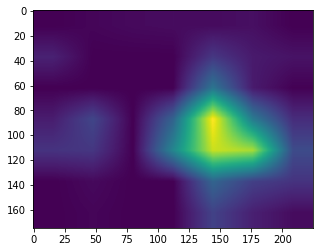

n02110627-affenpinscher


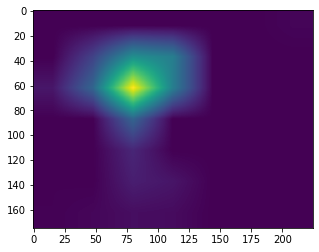

n02097130-giant_schnauzer


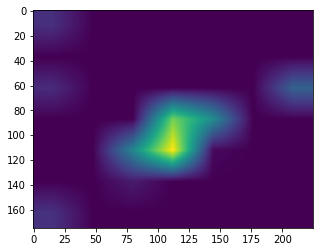

In [58]:
grad_cam_images = generate_grad_cam_with_top_n_class(cam_model, 'conv5_block3_out', item, debug=True)
for info in grad_cam_images:
    print(ds_info.features['label'].int2str(info['label']))
    plt.imshow(info['image'])
    plt.show()

- 같은 모델을 사용해서 역시 82, 100, 46 label을 추론 (앞에서부터 높은 확률)
- 하지만 실제 데이터의 레이블은 100
- cam 이미지와 달리 grad-cam 이미지는 범주에 따라 조금씩 다른 느낌

n02106382-bouvier_des_flandres


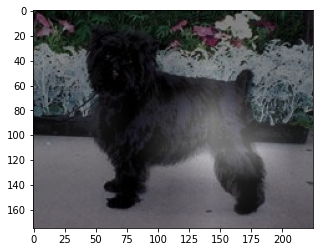

n02110627-affenpinscher


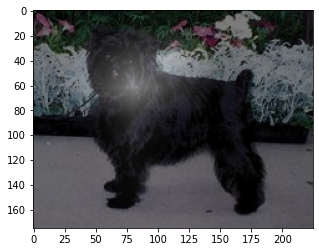

n02097130-giant_schnauzer


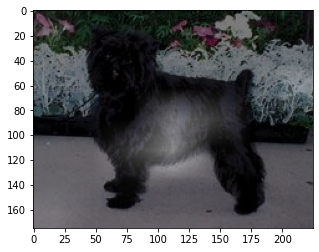

In [59]:
for info in grad_cam_images:
    print(ds_info.features['label'].int2str(info['label']))
    cam_image = info['image']
    visualize_cam_on_image(np.stack([cam_image*255]*3, axis=-1), item['image'])

- 첫 번째와 세 번째의 경우, 몸통을 보고 추론의 근거로 사용한 듯..
- 두 번째는 얼굴 부근을 보고 추론의 근거로 사용 -> 원래 범주

[ 82 100  46]
n02106382-bouvier_des_flandres
n02110627-affenpinscher
n02097130-giant_schnauzer
82
100
46
n02106382-bouvier_des_flandres


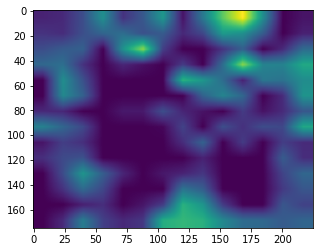

n02110627-affenpinscher


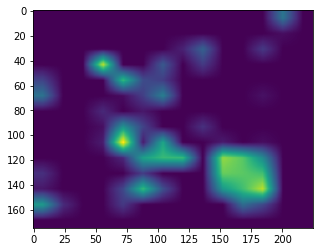

n02097130-giant_schnauzer


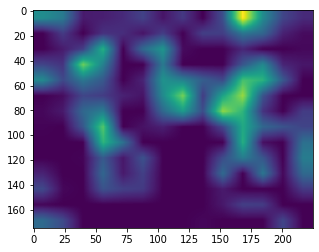

In [55]:
grad_cam_images = generate_grad_cam_with_top_n_class(cam_model, 'conv4_block3_out', item, debug=True)
for info in grad_cam_images:
    print(ds_info.features['label'].int2str(info['label']))
    plt.imshow(info['image'])
    plt.show()

n02106382-bouvier_des_flandres


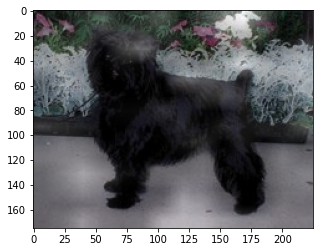

n02110627-affenpinscher


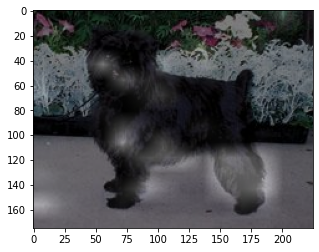

n02097130-giant_schnauzer


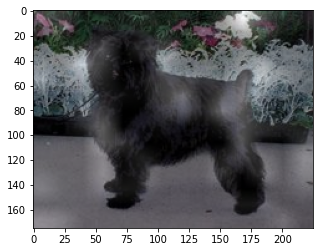

In [56]:
for info in grad_cam_images:
    print(ds_info.features['label'].int2str(info['label']))
    cam_image = info['image']
    visualize_cam_on_image(np.stack([cam_image*255]*3, axis=-1), item['image'])

- 첫 번째는 의미없는 배경 부분에 활성화되어 있음
- 두 번째와 세 번째는 특징적인 부분이 될 수 있는 다리나 꼬리 부분에 활성화되어 있음

![bouvier_des_flandres](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Bouvier2.JPG/220px-Bouvier2.JPG)
![affenpinscher](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Affenpinscher.jpg/220px-Affenpinscher.jpg)
![giant_schnauzer](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Nev_Lemar_Barbara1.jpg/220px-Nev_Lemar_Barbara1.jpg)

샘플 사진들을 보고 내가 판단할 수 있는 특징이랑 grad-cam에서 활성화된 부분이랑 비교하려고 했으나..  
셋 다 너무 비슷하게 생겨서 스킵..

### 회고
- Grad CAM을 사용하여 각 클래스마다 모델이 집중하는 부분이 다른 것을 알 수 있었음
- 그에 반해 CAM 이미지는 클래스에 무관하게 비슷한 곳이 활성화되어 있었음 why?
  - 일단 Grad CAM은 특정 클래스의 손실에 대한 그레디언트(모델이 특정 클래스에 대한 예측을 얼마나 변경시키는지)를 사용한거라, 각 클래스마다 다른 활성화 영역을 보인듯
  - CAM은 GAP 이후 가중치를 기반으로 활성화 맵을 계산해서 비슷한 부분에서 특징을 추출하면, 해당 영역이 뭉뚱그려서 표현되는듯.. 
- 다른 layer의 output 역시 확인할 수 있어서, 모델이 엉뚱한 곳을 주목했는지 알 수가 있었음

[CAM vs Grad-CAM으로 넘어가기](./0304_cam_grad_cam_impl.ipynb)